# Desafio: Predicción del valor de casas a través de metadata e imágenes

<span class="mark">Integrantes:</span> Mario Mallea,Maximiliano Ramírez, Hugo rocha.

<span class="mark">Equipo:</span> Juan Banach

In [1]:
#librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import missingno as msno 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

# Import necessary modules
from sklearn.metrics import mean_squared_error

# Keras specific
import keras
from keras.models import Sequential
from keras.layers import Dense

from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.models import Model
from keras.callbacks import ModelCheckpoint

from sklearn.metrics import classification_report

import tensorflow as tf
#import tensorflow_addons as tfa
from tensorflow import keras
import pydot


from numpy.random import seed
import random as python_random
import random

import warnings
warnings.filterwarnings("ignore")

import glob
import cv2
import os

seed(48)
python_random.seed(48)
tf.random.set_seed(48)



# Exploratorio

Se cargan los datos

In [29]:
test= pd.read_csv('metadata_casas_test.csv')
test = test.drop('Unnamed: 0', axis = 1)
train= pd.read_csv('metadata_casas_train.csv')
train = train.drop('Unnamed: 0', axis = 1)

In [30]:
print(train.shape, test.shape)

(443, 6) (92, 5)


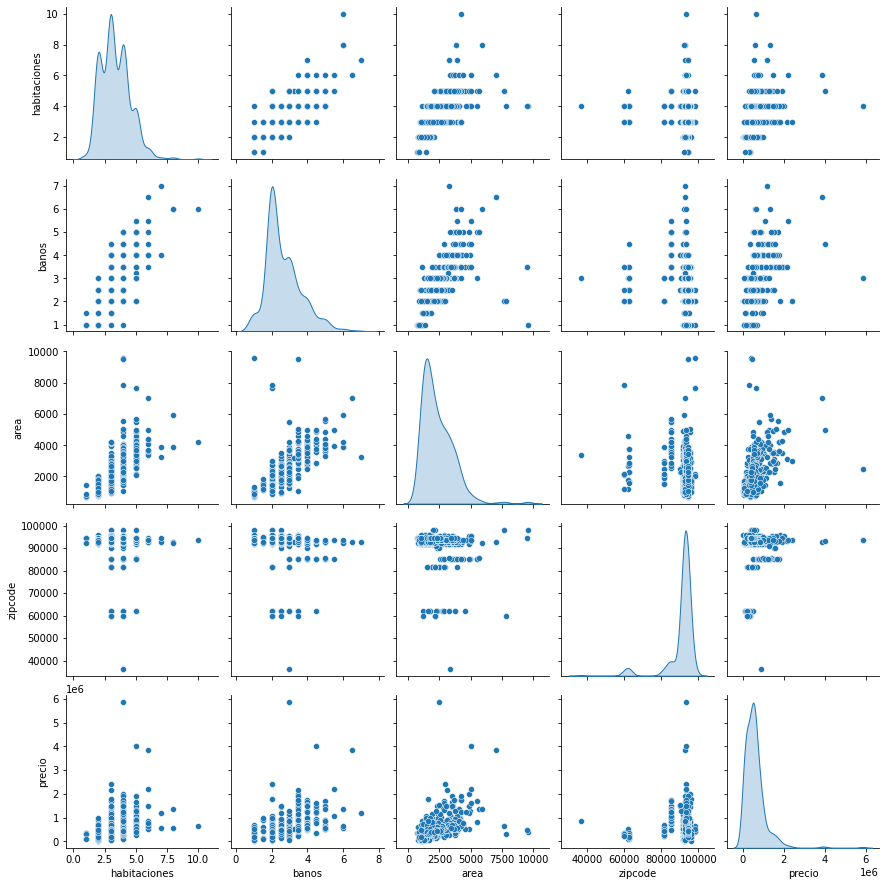

In [4]:
sns.pairplot(train[['habitaciones', 'banos', 'area', 'zipcode','precio']], diag_kind="kde")

Observación:

Tenemos grupos de zipcodes (zona geográficas) principales, alrededor de 60.000 (Illinois, Kansas, Missouri, Nebraska) con precios uniformes incluyendo al outlier en 30.000 (Alabama, Florida, Georgia, Mississippi, Tennessee, Army Post Office Americas, Fleet Post Office Americas), alrededor de 80.000( Arizona, Colorado, Idaho, New Mexico, Nevada, Utah, Wyoming) con precios diversos pero en un intervalo, y al rededor de 90.000 (Alaska, American Samoa, California, Guam, Hawaii, Marshall Islands, Federated States of Micronesia, Northern Mariana Islands, Oregon, Palau, Washington, Army Post Office Pacific, Fleet Post Office Pacific) con más diversos precios. 

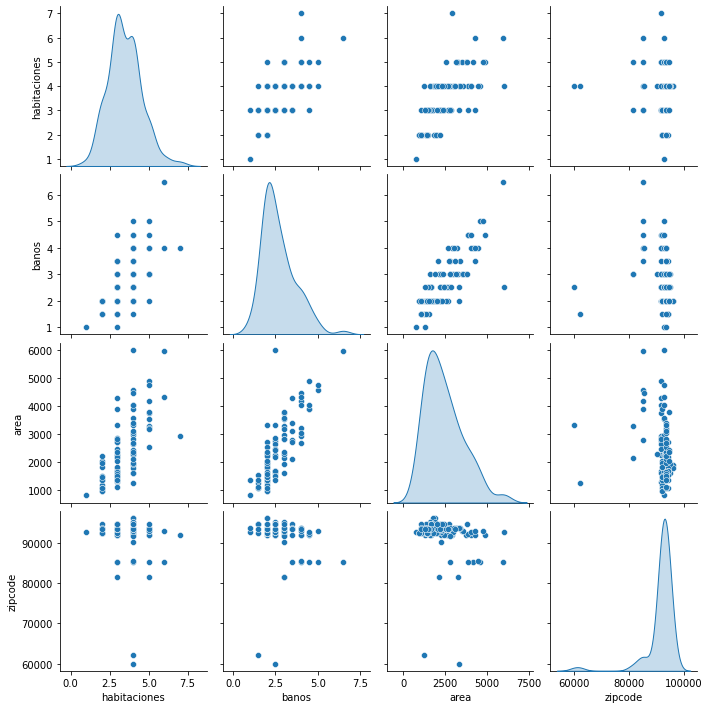

In [5]:
sns.pairplot(test[['habitaciones', 'banos', 'area', 'zipcode']], diag_kind="kde")

In [6]:
train.describe()

,habitaciones,banos,area,zipcode,precio
count,443.000000,443.000000,443.000000,443.000000,4.430000e+02
mean,3.358916,2.660835,2346.255079,90786.645598,5.798091e+05
std,1.182386,0.999268,1241.917375,7459.104896,5.298119e+05
min,1.000000,1.000000,701.000000,36372.000000,2.200000e+04
25%,2.000000,2.000000,1433.000000,92276.000000,2.270000e+05
50%,3.000000,2.500000,2024.000000,92880.000000,5.200000e+05
75%,4.000000,3.000000,3057.000000,93510.000000,7.001000e+05
max,10.000000,7.000000,9583.000000,98021.000000,5.858000e+06


In [7]:
test.describe()

,habitaciones,banos,area,zipcode
count,92.000000,92.000000,92.000000,92.000000
mean,3.467391,2.684783,2454.706522,91665.456522
std,1.053003,0.979789,1139.383287,5331.158230
min,1.000000,1.000000,800.000000,60046.000000
25%,3.000000,2.000000,1577.500000,91901.000000
50%,3.000000,2.500000,2249.000000,92778.500000
75%,4.000000,3.000000,3117.500000,93510.000000
max,7.000000,6.500000,6000.000000,96019.000000


# Pre procesamiento

Eliminamos del train outlier por categoría: top 3 precio, top baños,habitaciones y area. Zipcode zona 3.

In [31]:
max_list= set()
for column in ['habitaciones', 'banos', 'area' ,'precio']:
    max_list.add(train[column].idxmax())
max_list.add(train["zipcode"].idxmin())
train= train.drop(list(max_list)).reset_index(drop=True)
train= train.drop(train["precio"].idxmax()).reset_index(drop=True) #segundo mas caro
train= train.drop(train["precio"].idxmax()).reset_index(drop=True) #tercera mas caro
print(train.shape)

(436, 6)


El zipcode es una variable categorica que denota el barrio, ademas podrías capturar los zipcodes vecinos en caso de que existan, pero no existe una regla clara para esto y las probabilidades de tener vecinos son bajas.

Añadir información geográfica, con solo un one hot no permite al  modelo reconocer la relación de precios de vecinos, por ende con las siguiente función creamos un atributo que recoge la zona que pertenece el zipcode.

In [6]:
def vecinos(data):
    vecinos=[]
    for i in range(data.shape[0]):
        vecinos.append(int(data.zipcode[i]/10000))
    return vecinos
        
        

In [33]:
train["vecinos"]=vecinos(train)

Agregamos el atributo precio promedio por zipcode

In [34]:
promedio=dict()
for zipc in train.zipcode.unique():
    promedio[zipc]=train[train["zipcode"]==zipc].precio.mean()
train["prom_zip_precio"]=[0]*train.shape[0]
for i in range(train.shape[0]):
    train["prom_zip_precio"][i]=promedio[train.zipcode[i]]

In [35]:
X_num = train.drop(['precio','cod_casa','zipcode','vecinos'],axis=1).reset_index(drop=True)
X_cat = pd.get_dummies(train['zipcode'])
X_cat_v = pd.get_dummies(train['vecinos'])
X_1= pd.concat([X_num, X_cat,X_cat_v], axis=1).reset_index(drop=True)
y_1 = train['precio']
print(X_1.shape)

(436, 52)


## Imagenes

Transformaremos el problema de regresión por uno de <span class="mark">clasificación para las imágenes</span>, clasificaremos si la casa es de la más caras, medias o de las más baratas con Alexnet

In [36]:
#datos
y=[]   
total=train.shape[0]
for i in range(total):
   
    p25= train.precio.quantile(0.25)
    p5= train.precio.quantile(0.5)
    p75= train.precio.quantile(0.75)
    precio= train.precio[i]
    
    if  precio <= p25:
        y.append(1) 
    if  precio >p25 and precio <=p75:
        y.append(2)
    if  precio > p75:
        y.append(3)


In [9]:
print("cantidad de ejemplos por clases:",round(y.count(1)/total,2),round(y.count(2)/total,2),round(y.count(3)/total,2))

cantidad de ejemplos por clases: 0.25 0.5 0.25


In [7]:
#cargar imagenes
def cargar_imagenes(datos):
    
    if datos=="train":
        data= train
        im_b, im_c, im_f, im_p = [],[],[],[] #baño,cocina,frontal,pieza
        images=[]
        clases= ["bathroom","kitchen","frontal","bedroom"]
        tamaño= 227
        for i in data['cod_casa'].values: #cada casa
            inputImages = []
            outputImage = np.zeros((454, 454, 3), dtype="uint8")
            for tipo in clases:
                image =cv2.imread(os.path.join("fotos-casas", str(i)+"_"+tipo+".jpg"))
                image = cv2.resize(image, (tamaño, tamaño)) #fijar tamaño
                inputImages.append(image)

            im_b.append(inputImages[0])
            im_c.append(inputImages[1])
            im_f.append(inputImages[2])
            im_p.append(inputImages[3])

                        #cuadricula
            outputImage[0:tamaño, 0:tamaño] = inputImages[0]
            outputImage[0:tamaño, tamaño:tamaño*2] = inputImages[1]
            outputImage[tamaño:tamaño*2, tamaño:tamaño*2] = inputImages[2]
            outputImage[tamaño:tamaño*2, 0:tamaño] = inputImages[3]
            images.append(outputImage)

        return np.array(images)
    
    if datos=="test":

        data= test
        im_b, im_c, im_f, im_p = [],[],[],[] #baño,cocina,frontal,pieza
        images=[]
        clases= ["bathroom","kitchen","frontal","bedroom"]
        tamaño= 227
        for i in data['cod_casa'].values: #cada casa
            inputImages = []
            outputImage = np.zeros((454, 454, 3), dtype="uint8")
            for tipo in clases:
                image =cv2.imread(os.path.join("fotos-casas", str(i)+"_"+tipo+".jpg"))
                image = cv2.resize(image, (tamaño, tamaño)) #fijar tamaño
                inputImages.append(image)

            im_b.append(inputImages[0])
            im_c.append(inputImages[1])
            im_f.append(inputImages[2])
            im_p.append(inputImages[3])

                        #cuadricula
            outputImage[0:tamaño, 0:tamaño] = inputImages[0]
            outputImage[0:tamaño, tamaño:tamaño*2] = inputImages[1]
            outputImage[tamaño:tamaño*2, tamaño:tamaño*2] = inputImages[2]
            outputImage[tamaño:tamaño*2, 0:tamaño] = inputImages[3]
            images.append(outputImage)

        return np.array(images)
        

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 111, 111, 96)      34944     
_________________________________________________________________
batch_normalization (BatchNo (None, 111, 111, 96)      384       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 55, 55, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 55, 55, 256)       614656    
_________________________________________________________________
batch_normalization_1 (Batch (None, 55, 55, 256)       1024      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 27, 27, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 27, 27, 384)       8

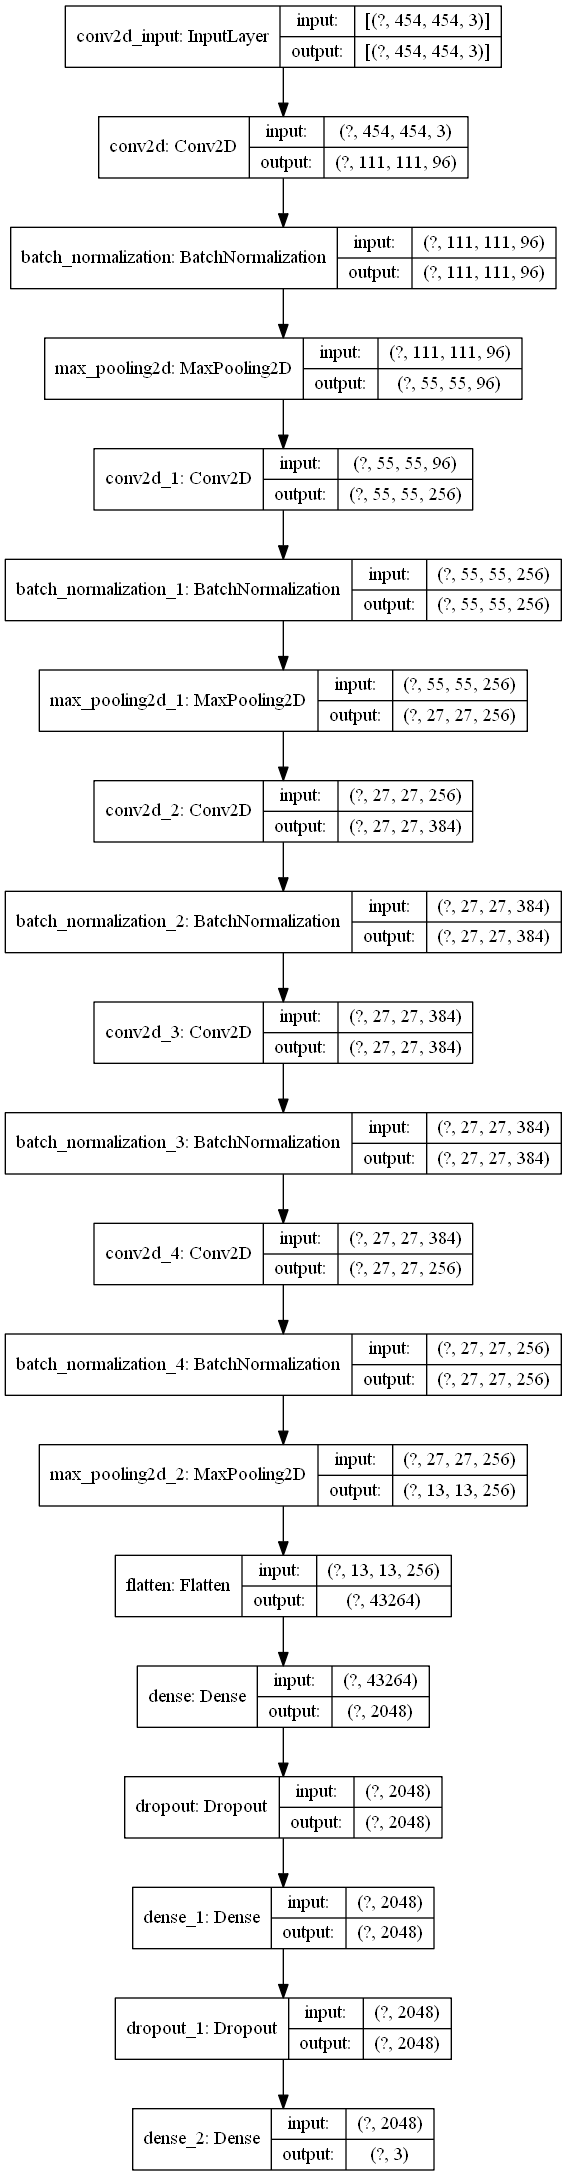

In [3]:
n_clases= 3
alex_net = keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(454,454,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(n_clases, activation='softmax')
])
alex_net.summary()

keras.utils.plot_model(alex_net, show_shapes=True)

In [37]:
X= cargar_imagenes("train")
Y= pd.get_dummies(np.array(y))
print("X,y Shapes:", X.shape, Y.shape)

X,y Shapes: (436, 454, 454, 3) (436, 3)


In [38]:
#split
X_train, X_val, y_train, y_val, ind_train, ind_val = train_test_split(X, Y,train.index, test_size=0.2, shuffle=True)

Durante la validación no es necesario ocupar Alexnet pues la clasificación de casas por rangos de precio se puede hacer de manera determinista.

In [39]:
X_1["clase_Casa_foto"]=y

# Modelamiento

In [40]:
X_2= pd.concat([X_1,pd.get_dummies(X_1["clase_Casa_foto"])], axis=1).drop(["clase_Casa_foto"],axis=1)
print(X_2.shape)

(436, 55)


In [41]:
X_train, X_val= X_2.iloc[ind_train],X_2.iloc[ind_val]
y_train, y_val= y_1.iloc[ind_train],y_1.iloc[ind_val]

#normalizacion de area
scaler_std_area=X_train.area.std()
scaler_mean_area=X_train.area.mean()
X_train.area=(X_train.area-scaler_mean_area)/scaler_std_area
X_val.area=(X_val.area-scaler_mean_area)/scaler_std_area
print(X_train.shape, X_val.shape,y_train.shape,y_val.shape)

(348, 55) (88, 55) (348,) (88,)


## Arquitecturas

Tras diferentes pruebas, decidimos trabajar con la siguiente arquitectura base

In [16]:
def custom_DNN(dim_entrada, n): #numero de neuronas=n
    model2 = Sequential()
    model2.add(Dense(6*n, input_dim=dim_entrada, activation= "relu"))
    model2.add(Dense(4*n, activation= "relu"))
    model2.add(Dense(3*n, activation= "relu"))
    model2.add(Dense(2*n, activation= "relu"))
    model2.add(Dense(n, activation= "relu"))
    model2.add(Dense(int(n/2), activation= "relu"))
    model2.add(Dense(int(n/4), activation= "relu"))
    model2.add(Dense(int(n/10), activation= "relu"))
    model2.add(Dense(1))
    #model2.summary()
    return model2

## Predicciones

In [43]:
model2= custom_DNN(X_train.shape[1], 100)
model2.compile(loss= "mean_squared_error" , optimizer= keras.optimizers.Adam(lr=0.005, decay=5e-4), metrics=["mean_squared_error"])
history = model2.fit(X_train, y_train, validation_data = (X_val, y_val), epochs=75, batch_size=32,verbose=0)

Error en el Train:  266733.62179003493
Error en el Test:  59145676573.77307


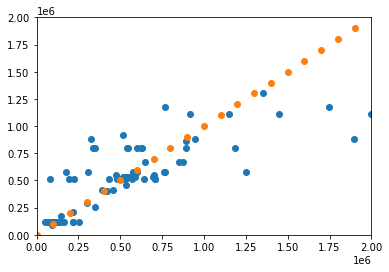

In [44]:
y_pred=model2.predict(X_val)
pred_train = model2.predict(X_train)
x= np.arange(0,2e6,100000)
print('Error en el Train: ',np.sqrt(mean_squared_error(y_train,pred_train)))
print('Error en el Test: ',mean_squared_error(y_val,y_pred))
plt.scatter(y_val.tolist(), pd.DataFrame(y_pred)[0].tolist())
plt.scatter(x, x)
plt.xlim(0, 2e6)
plt.ylim(0,2e6)
plt.show()

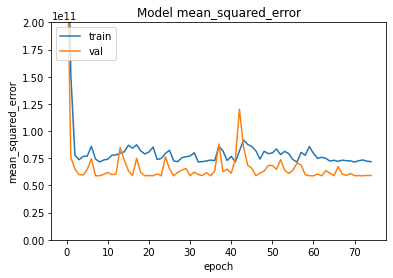

In [52]:
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('Model mean_squared_error')
plt.ylabel('mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.ylim(0,2e+11)
plt.show()

## Comparación con Random Forest

Error en el Test:  29429044874.721523


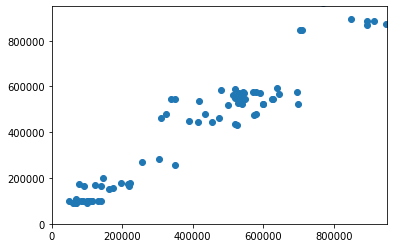

In [42]:
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(max_depth=5, random_state=0)
regr.fit(X_train, y_train)

y_pred=regr.predict(X_val)
#pred_train = regr.predict(X_train)

#print('Error en el Train: ',np.sqrt(mean_squared_error(y_train,pred_train)))
print('Error en el Test: ',mean_squared_error(y_val,y_pred))
plt.scatter(y_val.tolist(), pd.DataFrame(y_pred)[0].tolist())
plt.xlim(0, 950000)
plt.ylim(0, 950000)
plt.show()

In [16]:
%%time
kf = KFold(n_splits=10,shuffle=True)
errores=[]
#Total de --- modelos
c=0
for train_index, val_index in kf.split(X_2):
    print('iterando')
    modelos=[]
    X_train, X_val = X_2.loc[train_index], X_2.loc[val_index]
    y_train, y_val = y_1.loc[train_index], y_1.loc[val_index]
    #normalizacion de area
    scaler_std_area=X_train.area.std()
    scaler_mean_area=X_train.area.mean()
    X_train.area=(X_train.area-scaler_mean_area)/scaler_std_area
    X_val.area=(X_val.area-scaler_mean_area)/scaler_std_area
    #Probamos diferentes hiperparametros
    learn_rate=[0.005,0.01,0.025,0.001]
    epoca=[30,50,75,100,200]
    n_nodes=[50,100,200]
    #Seran -- modelos. por cada distirbucion de datos que son -- distirbuciones distintas
    for l in learn_rate:
        for e in epoca:
            for n in n_nodes:
                print(l,e,n)
                NN_model= custom_DNN(X_train.shape[1],n)
                # Compile the network :
                NN_model.compile(loss= "mean_squared_error",  optimizer= keras.optimizers.Adam(lr=l, decay=5e-4), metrics=[ "mean_squared_error"])
                history = NN_model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs=e, batch_size=32 , verbose=0)
                y_pred= NN_model.predict(X_val)
                modelos.append((mean_squared_error(y_val,y_pred),l,e,n))
                errores.append(modelos) #Esta lista guardara todo los modelos para una distirbucion de datos en particular

iterando
0.005 30 50
0.005 30 100
0.005 30 200
0.005 50 50
0.005 50 100
0.005 50 200
0.005 75 50
0.005 75 100
0.005 75 200
0.005 100 50
0.005 100 100
0.005 100 200
0.005 200 50
0.005 200 100
0.005 200 200
0.01 30 50
0.01 30 100
0.01 30 200
0.01 50 50
0.01 50 100
0.01 50 200
0.01 75 50
0.01 75 100
0.01 75 200
0.01 100 50
0.01 100 100
0.01 100 200
0.01 200 50
0.01 200 100
0.01 200 200
0.025 30 50
0.025 30 100
0.025 30 200
0.025 50 50
0.025 50 100
0.025 50 200
0.025 75 50
0.025 75 100
0.025 75 200
0.025 100 50
0.025 100 100
0.025 100 200
0.025 200 50
0.025 200 100
0.025 200 200
0.001 30 50
0.001 30 100
0.001 30 200
0.001 50 50
0.001 50 100
0.001 50 200
0.001 75 50
0.001 75 100
0.001 75 200
0.001 100 50
0.001 100 100
0.001 100 200
0.001 200 50
0.001 200 100
0.001 200 200
iterando
0.005 30 50
0.005 30 100
0.005 30 200
0.005 50 50
0.005 50 100
0.005 50 200
0.005 75 50
0.005 75 100
0.005 75 200
0.005 100 50
0.005 100 100
0.005 100 200
0.005 200 50
0.005 200 100
0.005 200 200
0.01 30 50
0.01 3

In [58]:
K_folds=[]
for i in range(10):
    K_folds.append(errores[60*i])

In [63]:
errores_1=K_folds

In [64]:
Promedios=list()
mini=100000000000000000
for i in range(len(errores_1)): #cantidad de modelos probados
    y=0
    for kfolds in errores_1:
        y+=kfolds[i][0]
    prom=y/10
    if prom <= mini:
        mini=prom
        i_min=i
print('El mejor modelo con error ',mini,' , tiene parametros learning rate',errores_1[0][i_min][1] , ' ,epocas igual a ',errores_1[0][i_min][2], 'y neuronas primera capa iguales a ', errores_1[0][i_min][3] )

El mejor modelo con error  69107284109.15352  , tiene parametros learning rate 0.005  ,epocas igual a  100 y neuronas primera capa iguales a  50


# Evaluando el modelo final

El input del modelo Final consiste en:

**Metadata+ <span class="girk">Clasificación tramo del precio por fotos</span> + vecinos + promedio precio por zipcode <span class="burk">-></span> precio.**




<span class="girk">Red conv: Alexnet</span>

<span class="burk">Red densa ff: Custom</span> 


In [3]:
#datos
test= pd.read_csv('metadata_casas_test.csv')
test = test.drop('Unnamed: 0', axis = 1)
train= pd.read_csv('metadata_casas_train.csv')
train = train.drop('Unnamed: 0', axis = 1)

# prepocesamiento train
max_list= set()
for column in ['habitaciones', 'banos', 'area' ,'precio']:
    max_list.add(train[column].idxmax())
max_list.add(train["zipcode"].idxmin())
train= train.drop(list(max_list)).reset_index()
train= train.drop(train["precio"].idxmax()).reset_index(drop=True) #segundo mas caro
train= train.drop(train["precio"].idxmax()).reset_index(drop=True) #tercera mas caro
print(train.shape)

promedio=dict()
for zipc in train.zipcode.unique():
    promedio[zipc]=train[train["zipcode"]==zipc].precio.mean()
train["prom_zip_precio"]=[0]*train.shape[0]
for i in range(train.shape[0]):
    train["prom_zip_precio"][i]=promedio[train.zipcode[i]]

(436, 7)


In [4]:
y_2_train = train['precio']

In [8]:
train["vecinos"]=vecinos(train)

X_num = train.drop(['precio','cod_casa','zipcode'],axis=1)
X_cat = pd.get_dummies(train['zipcode'])
X_cat_v = pd.get_dummies(train['vecinos'])

X_1= pd.concat([X_num, X_cat,X_cat_v], axis=1)

X_train_im= cargar_imagenes("train")

#clasificacion tramos precios
y=[]   
total=train.shape[0]
for i in range(total):
   
    p25= train.precio.quantile(0.25)
    p5= train.precio.quantile(0.5)
    p75= train.precio.quantile(0.75)
    precio= train.precio[i]
    
    if  precio <= p25:
        y.append(1) 
    if  precio >p25 and precio <=p75:
        y.append(2)
    if  precio > p75:
        y.append(3)

Y_train_im= pd.get_dummies(np.array(y))
print("X,y Shapes:", X_train_im.shape, Y_train_im.shape)

#modelo cuadricula


X,y Shapes: (436, 454, 454, 3) (436, 3)


In [ ]:
model= alex_net
model.compile( loss='categorical_crossentropy', optimizer = keras.optimizers.Adam(learning_rate=0.001))
history = model.fit(
    x = X_train_im,
    y = Y_train_im,
    batch_size=32,
    epochs=50, #aumentar con 18 vale
    verbose=1)

In [9]:
#model.save('alex_net.h5')
model = keras.models.load_model('alex_net_bien.h5')
X_1["clase_Casa_foto"]= y # deterministico, porque estoy en el train 
X_1_area_mean=X_1.area.mean()
X_1_area_std=X_1.area.std()
X_1.area=(X_1.area-X_1_area_mean)/X_1_area_std
X_2_train= pd.concat([X_1,pd.get_dummies(X_1["clase_Casa_foto"])], axis=1).drop(["clase_Casa_foto"],axis=1)

In [10]:
X_2_train= X_2_train.drop(["index"],axis=1).reset_index(drop=True)
X_2_train=X_2_train.drop(["vecinos"],axis=1)
X_2_train

,habitaciones,banos,area,prom_zip_precio,60002,60016,62025,62034,62088,62214,...,95008,95220,96019,98021,6,8,9,1,2,3
0,4,4.0,1.495897,1077711,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
1,3,4.0,1.384707,946442,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
2,5,5.0,1.469382,1198812,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
3,3,4.0,1.549781,946442,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
4,3,4.0,0.205245,1198812,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
431,4,3.0,0.172744,427699,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
432,4,2.5,-0.058188,427699,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
433,5,2.0,-0.203589,427699,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
434,4,3.5,6.185521,427699,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0


In [11]:
# prepocesamiento test
test["prom_zip_precio"]=[0]*test.shape[0]
for i in range(test.shape[0]):
    if test.zipcode[i] in promedio:
        test["prom_zip_precio"][i]=promedio[test.zipcode[i]]
    else:
        test["prom_zip_precio"][i]=np.median(list(promedio.values())) #imputacion por mediana
        

test["vecinos"]=vecinos(test)

X_num = test.drop(['cod_casa','zipcode'],axis=1)
X_cat = pd.get_dummies(test['zipcode'])
X_cat_v = pd.get_dummies(test['vecinos'])

X_1_test= pd.concat([X_num, X_cat,X_cat_v], axis=1)

X_test_im= cargar_imagenes("test")
y_test_pred= model.predict(X_test_im) #alex net

y_list_test_pred=[]
for i in np.argmax(y_test_pred,axis=1): 
        if i==0:
            y_list_test_pred.append(1)
        if i==1:
            y_list_test_pred.append(2)
        if i==2:
            y_list_test_pred.append(3)

X_1_test["clase_Casa_foto"]= y_list_test_pred # estocástico 
X_1_test.area=(X_1_test.area-X_1_area_mean)/X_1_area_std
X_2_test= pd.concat([X_1_test,pd.get_dummies(X_1_test["clase_Casa_foto"])], axis=1).drop(["clase_Casa_foto"],axis=1)    

In [12]:
X_2_test=X_2_test.drop(["vecinos"],axis=1)
X_2_test

,habitaciones,banos,area,prom_zip_precio,60046,62234,81524,85255,85262,85266,...,94501,94531,95220,96019,6,8,9,1,2,3
0,4,5.0,1.947497,946442,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,1,0
1,5,4.0,1.613073,1077711,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,1,0
2,6,6.5,3.129525,1198812,0,0,0,0,1,0,...,0,0,0,0,0,1,0,1,0,0
3,4,4.0,1.847426,1187000,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
4,3,4.5,1.359048,1077711,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,4,4.0,0.322422,599251,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
88,4,2.5,0.100898,427699,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,1,0
89,4,2.0,0.025632,427699,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,1,0
90,3,2.0,-0.248065,427699,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,1,0


para que las dimensiones tras el one hot coincidan

In [13]:
#se completan los zipcode faltantes segun corresponda
zip_train=set(train.zipcode.values)
zip_test=set(test.zipcode.values)
zip_code_diferentes=(zip_test)- zip_train&zip_test
for i in zip_code_diferentes:
    X_2_train[str(i)]= [0]*436
zip_code_d=(zip_train)- (zip_train&zip_test)
for i in zip_code_d:
    X_2_test[str(i)]= [0]*92

In [14]:
print(X_2_train.shape,X_2_test.shape, y_2_train.shape)

(436, 58) (92, 58) (436,)


CV k fold: El mejor modelo con error  69107284109.15352  , tiene parametros learning rate 0.005  ,epocas igual a  100 y neuronas primera capa iguales a  50

In [23]:
#modelo final
final=custom_DNN(X_2_train.shape[1], 50)
final.compile(loss= "mean_squared_error",  optimizer= keras.optimizers.Adam(lr= 0.005 , decay=5e-4), metrics=[ "mean_squared_error"])
history = final.fit(X_2_train, y_2_train, epochs= 100, batch_size=32 , verbose=1, shuffle=True)
predicciones_test= final.predict(X_2_test)


Epoch 1/1501
14/14 [==============================] - 0s 1ms/step - loss: 141183205376.0000 - mean_squared_error: 141183205376.0000
Epoch 2/1501
14/14 [==============================] - 0s 1ms/step - loss: 72678760448.0000 - mean_squared_error: 72678760448.0000
Epoch 3/1501
14/14 [==============================] - 0s 1ms/step - loss: 81072054272.0000 - mean_squared_error: 81072054272.0000
Epoch 4/1501
14/14 [==============================] - 0s 1ms/step - loss: 69583978496.0000 - mean_squared_error: 69583978496.0000
Epoch 5/1501
14/14 [==============================] - 0s 1ms/step - loss: 70736617472.0000 - mean_squared_error: 70736617472.0000
Epoch 6/1501
14/14 [==============================] - 0s 1ms/step - loss: 72712880128.0000 - mean_squared_error: 72712880128.0000
Epoch 7/1501
14/14 [==============================] - 0s 1ms/step - loss: 72699404288.0000 - mean_squared_error: 72699404288.0000
Epoch 8/1501
14/14 [==============================] - 0s 1ms/step - loss: 70016835584.00

14/14 [==============================] - 0s 1ms/step - loss: 71976214528.0000 - mean_squared_error: 71976214528.0000
Epoch 126/1501
14/14 [==============================] - 0s 1ms/step - loss: 69027774464.0000 - mean_squared_error: 69027774464.0000
Epoch 127/1501
14/14 [==============================] - 0s 1ms/step - loss: 68145618944.0000 - mean_squared_error: 68145618944.0000
Epoch 128/1501
14/14 [==============================] - 0s 1ms/step - loss: 69197275136.0000 - mean_squared_error: 69197275136.0000
Epoch 129/1501
14/14 [==============================] - 0s 1ms/step - loss: 70623453184.0000 - mean_squared_error: 70623453184.0000
Epoch 130/1501
14/14 [==============================] - 0s 1ms/step - loss: 71639752704.0000 - mean_squared_error: 71639752704.0000
Epoch 131/1501
14/14 [==============================] - 0s 1ms/step - loss: 78338400256.0000 - mean_squared_error: 78338400256.0000
Epoch 132/1501
14/14 [==============================] - 0s 1ms/step - loss: 70701760512.000

14/14 [==============================] - 0s 1ms/step - loss: 68856111104.0000 - mean_squared_error: 68856111104.0000
Epoch 250/1501
14/14 [==============================] - 0s 1ms/step - loss: 68794900480.0000 - mean_squared_error: 68794900480.0000
Epoch 251/1501
14/14 [==============================] - 0s 1ms/step - loss: 68827627520.0000 - mean_squared_error: 68827627520.0000
Epoch 252/1501
14/14 [==============================] - 0s 1ms/step - loss: 69033582592.0000 - mean_squared_error: 69033582592.0000
Epoch 253/1501
14/14 [==============================] - 0s 1ms/step - loss: 73905881088.0000 - mean_squared_error: 73905881088.0000
Epoch 254/1501
14/14 [==============================] - 0s 1ms/step - loss: 69050204160.0000 - mean_squared_error: 69050204160.0000
Epoch 255/1501
14/14 [==============================] - 0s 1ms/step - loss: 69727092736.0000 - mean_squared_error: 69727092736.0000
Epoch 256/1501
14/14 [==============================] - 0s 1ms/step - loss: 68525187072.000

14/14 [==============================] - 0s 1ms/step - loss: 68579827712.0000 - mean_squared_error: 68579827712.0000
Epoch 374/1501
14/14 [==============================] - 0s 1ms/step - loss: 69087682560.0000 - mean_squared_error: 69087682560.0000
Epoch 375/1501
14/14 [==============================] - 0s 1ms/step - loss: 68837490688.0000 - mean_squared_error: 68837490688.0000
Epoch 376/1501
14/14 [==============================] - 0s 1ms/step - loss: 69803171840.0000 - mean_squared_error: 69803171840.0000
Epoch 377/1501
14/14 [==============================] - 0s 1ms/step - loss: 68887101440.0000 - mean_squared_error: 68887101440.0000
Epoch 378/1501
14/14 [==============================] - 0s 1ms/step - loss: 69896929280.0000 - mean_squared_error: 69896929280.0000
Epoch 379/1501
14/14 [==============================] - 0s 1ms/step - loss: 69366210560.0000 - mean_squared_error: 69366210560.0000
Epoch 380/1501
14/14 [==============================] - 0s 1ms/step - loss: 68555214848.000

14/14 [==============================] - 0s 1ms/step - loss: 68671635456.0000 - mean_squared_error: 68671635456.0000
Epoch 498/1501
14/14 [==============================] - 0s 1ms/step - loss: 68852457472.0000 - mean_squared_error: 68852457472.0000
Epoch 499/1501
14/14 [==============================] - 0s 1ms/step - loss: 68429611008.0000 - mean_squared_error: 68429611008.0000
Epoch 500/1501
14/14 [==============================] - 0s 1ms/step - loss: 70566469632.0000 - mean_squared_error: 70566469632.0000
Epoch 501/1501
14/14 [==============================] - 0s 1ms/step - loss: 71088193536.0000 - mean_squared_error: 71088193536.0000
Epoch 502/1501
14/14 [==============================] - 0s 1ms/step - loss: 69283266560.0000 - mean_squared_error: 69283266560.0000
Epoch 503/1501
14/14 [==============================] - 0s 1ms/step - loss: 69976293376.0000 - mean_squared_error: 69976293376.0000
Epoch 504/1501
14/14 [==============================] - 0s 1ms/step - loss: 68725923840.000

14/14 [==============================] - 0s 1ms/step - loss: 69101928448.0000 - mean_squared_error: 69101928448.0000
Epoch 622/1501
14/14 [==============================] - 0s 1ms/step - loss: 68932526080.0000 - mean_squared_error: 68932526080.0000
Epoch 623/1501
14/14 [==============================] - 0s 1ms/step - loss: 69411930112.0000 - mean_squared_error: 69411930112.0000
Epoch 624/1501
14/14 [==============================] - 0s 1ms/step - loss: 68748689408.0000 - mean_squared_error: 68748689408.0000
Epoch 625/1501
14/14 [==============================] - 0s 1ms/step - loss: 69490491392.0000 - mean_squared_error: 69490491392.0000
Epoch 626/1501
14/14 [==============================] - 0s 1ms/step - loss: 69573181440.0000 - mean_squared_error: 69573181440.0000
Epoch 627/1501
14/14 [==============================] - 0s 1ms/step - loss: 68564000768.0000 - mean_squared_error: 68564000768.0000
Epoch 628/1501
14/14 [==============================] - 0s 1ms/step - loss: 68455297024.000

14/14 [==============================] - 0s 1ms/step - loss: 68970848256.0000 - mean_squared_error: 68970848256.0000
Epoch 746/1501
14/14 [==============================] - 0s 1ms/step - loss: 68602429440.0000 - mean_squared_error: 68602429440.0000
Epoch 747/1501
14/14 [==============================] - 0s 1ms/step - loss: 68343939072.0000 - mean_squared_error: 68343939072.0000
Epoch 748/1501
14/14 [==============================] - 0s 1ms/step - loss: 68718014464.0000 - mean_squared_error: 68718014464.0000
Epoch 749/1501
14/14 [==============================] - 0s 1ms/step - loss: 68573519872.0000 - mean_squared_error: 68573519872.0000
Epoch 750/1501
14/14 [==============================] - 0s 1ms/step - loss: 68254429184.0000 - mean_squared_error: 68254429184.0000
Epoch 751/1501
14/14 [==============================] - 0s 1ms/step - loss: 69110112256.0000 - mean_squared_error: 69110112256.0000
Epoch 752/1501
14/14 [==============================] - 0s 1ms/step - loss: 71116447744.000

14/14 [==============================] - 0s 1ms/step - loss: 68694540288.0000 - mean_squared_error: 68694540288.0000
Epoch 870/1501
14/14 [==============================] - 0s 1ms/step - loss: 68943527936.0000 - mean_squared_error: 68943527936.0000
Epoch 871/1501
14/14 [==============================] - 0s 1ms/step - loss: 69688098816.0000 - mean_squared_error: 69688098816.0000
Epoch 872/1501
14/14 [==============================] - 0s 1ms/step - loss: 68750966784.0000 - mean_squared_error: 68750966784.0000
Epoch 873/1501
14/14 [==============================] - 0s 1ms/step - loss: 68661358592.0000 - mean_squared_error: 68661358592.0000
Epoch 874/1501
14/14 [==============================] - 0s 1ms/step - loss: 68625756160.0000 - mean_squared_error: 68625756160.0000
Epoch 875/1501
14/14 [==============================] - 0s 1ms/step - loss: 68522012672.0000 - mean_squared_error: 68522012672.0000
Epoch 876/1501
14/14 [==============================] - 0s 1ms/step - loss: 68363087872.000

14/14 [==============================] - 0s 1ms/step - loss: 68941152256.0000 - mean_squared_error: 68941152256.0000
Epoch 994/1501
14/14 [==============================] - 0s 1ms/step - loss: 69725446144.0000 - mean_squared_error: 69725446144.0000
Epoch 995/1501
14/14 [==============================] - 0s 1ms/step - loss: 68780933120.0000 - mean_squared_error: 68780933120.0000
Epoch 996/1501
14/14 [==============================] - 0s 1ms/step - loss: 68356018176.0000 - mean_squared_error: 68356018176.0000
Epoch 997/1501
14/14 [==============================] - 0s 1ms/step - loss: 68518039552.0000 - mean_squared_error: 68518039552.0000
Epoch 998/1501
14/14 [==============================] - 0s 1ms/step - loss: 68309311488.0000 - mean_squared_error: 68309311488.0000
Epoch 999/1501
14/14 [==============================] - 0s 1ms/step - loss: 68698505216.0000 - mean_squared_error: 68698505216.0000
Epoch 1000/1501
14/14 [==============================] - 0s 1ms/step - loss: 68274675712.00

14/14 [==============================] - 0s 1ms/step - loss: 68835639296.0000 - mean_squared_error: 68835639296.0000
Epoch 1116/1501
14/14 [==============================] - 0s 1ms/step - loss: 69569552384.0000 - mean_squared_error: 69569552384.0000
Epoch 1117/1501
14/14 [==============================] - 0s 1ms/step - loss: 68655656960.0000 - mean_squared_error: 68655656960.0000
Epoch 1118/1501
14/14 [==============================] - 0s 1ms/step - loss: 68868587520.0000 - mean_squared_error: 68868587520.0000
Epoch 1119/1501
14/14 [==============================] - 0s 1ms/step - loss: 68317872128.0000 - mean_squared_error: 68317872128.0000
Epoch 1120/1501
14/14 [==============================] - 0s 1ms/step - loss: 68429709312.0000 - mean_squared_error: 68429709312.0000
Epoch 1121/1501
14/14 [==============================] - 0s 1ms/step - loss: 68443013120.0000 - mean_squared_error: 68443013120.0000
Epoch 1122/1501
14/14 [==============================] - 0s 1ms/step - loss: 68868841

14/14 [==============================] - 0s 1ms/step - loss: 68346122240.0000 - mean_squared_error: 68346122240.0000
Epoch 1238/1501
14/14 [==============================] - 0s 1ms/step - loss: 68438573056.0000 - mean_squared_error: 68438573056.0000
Epoch 1239/1501
14/14 [==============================] - 0s 1ms/step - loss: 68888649728.0000 - mean_squared_error: 68888649728.0000
Epoch 1240/1501
14/14 [==============================] - 0s 1ms/step - loss: 68223041536.0000 - mean_squared_error: 68223041536.0000
Epoch 1241/1501
14/14 [==============================] - 0s 1ms/step - loss: 68386111488.0000 - mean_squared_error: 68386111488.0000
Epoch 1242/1501
14/14 [==============================] - 0s 1ms/step - loss: 68654243840.0000 - mean_squared_error: 68654243840.0000
Epoch 1243/1501
14/14 [==============================] - 0s 1ms/step - loss: 69658910720.0000 - mean_squared_error: 69658910720.0000
Epoch 1244/1501
14/14 [==============================] - 0s 1ms/step - loss: 68556296

14/14 [==============================] - 0s 1ms/step - loss: 69866758144.0000 - mean_squared_error: 69866758144.0000
Epoch 1360/1501
14/14 [==============================] - 0s 1ms/step - loss: 67968839680.0000 - mean_squared_error: 67968839680.0000
Epoch 1361/1501
14/14 [==============================] - 0s 1ms/step - loss: 69074690048.0000 - mean_squared_error: 69074690048.0000
Epoch 1362/1501
14/14 [==============================] - 0s 1ms/step - loss: 68515676160.0000 - mean_squared_error: 68515676160.0000
Epoch 1363/1501
14/14 [==============================] - 0s 1ms/step - loss: 69469437952.0000 - mean_squared_error: 69469437952.0000
Epoch 1364/1501
14/14 [==============================] - 0s 1ms/step - loss: 68449640448.0000 - mean_squared_error: 68449640448.0000
Epoch 1365/1501
14/14 [==============================] - 0s 1ms/step - loss: 68471484416.0000 - mean_squared_error: 68471484416.0000
Epoch 1366/1501
14/14 [==============================] - 0s 1ms/step - loss: 68389310

14/14 [==============================] - 0s 1ms/step - loss: 68212047872.0000 - mean_squared_error: 68212047872.0000
Epoch 1482/1501
14/14 [==============================] - 0s 1ms/step - loss: 68557119488.0000 - mean_squared_error: 68557119488.0000
Epoch 1483/1501
14/14 [==============================] - 0s 1ms/step - loss: 68475506688.0000 - mean_squared_error: 68475506688.0000
Epoch 1484/1501
14/14 [==============================] - 0s 1ms/step - loss: 68221706240.0000 - mean_squared_error: 68221706240.0000
Epoch 1485/1501
14/14 [==============================] - 0s 1ms/step - loss: 68425662464.0000 - mean_squared_error: 68425662464.0000
Epoch 1486/1501
14/14 [==============================] - 0s 1ms/step - loss: 68284620800.0000 - mean_squared_error: 68284620800.0000
Epoch 1487/1501
14/14 [==============================] - 0s 1ms/step - loss: 68430172160.0000 - mean_squared_error: 68430172160.0000
Epoch 1488/1501
14/14 [==============================] - 0s 1ms/step - loss: 69084233

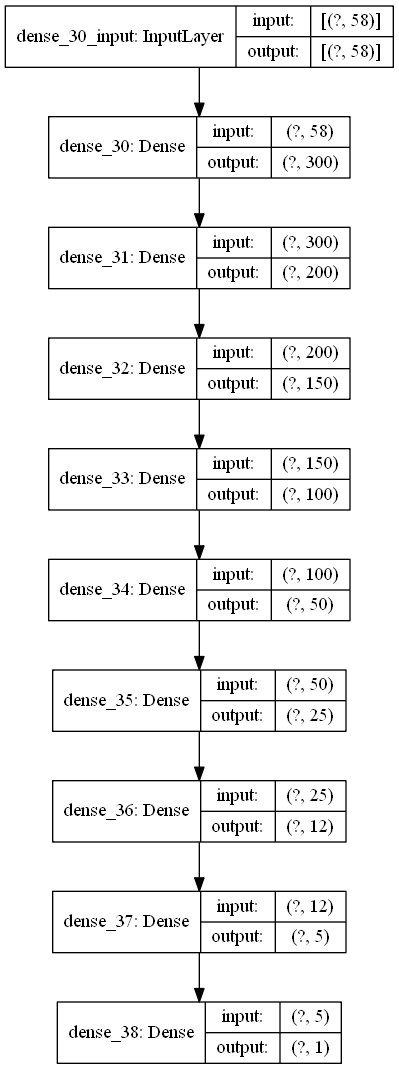

In [28]:
keras.utils.plot_model(custom_DNN(X_2_train.shape[1], 50), show_shapes=True)

In [26]:
entregable=[]
for i in range(predicciones_test.shape[0]):
    entregable.append(round(predicciones_test[i][0]))
    
d = {"'value'": entregable}
df = pd.DataFrame(data=d)
indices=[]
test_= pd.read_csv('metadata_casas_test.csv')
for i in test_["Unnamed: 0"]:
    indices.append("'"+str(i)+"'")
df.index= indices
df.index.name = "'id'"


In [28]:
df

,'value'
'id',
'5',945357
'18',1076245
'21',1197657
'28',1185243
'35',1076088
...,...
'503',598583
'516',427253
'519',427193


In [27]:
df.to_csv("sampleSubmission.csv")

In [213]:
X_2_test.to_csv("X_2_test.csv")
X_2_train.to_csv("X_2_train.csv")

## Bitacóra resultados Kaggle:

La primera vez "SampleSubmission_1" nuestro resultado fue de 242.105.083.676= 242.105 Millones, será por outliers?

In [46]:
entrega1= pd.read_csv('sampleSubmission_1.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'sampleSubmission_1.csv'

In [12]:
entrega1.describe()

,'value'
count,9.200000e+01
mean,5.982994e+05
std,4.205489e+05
min,4.560200e+04
25%,2.634642e+05
50%,5.266185e+05
75%,8.607520e+05
max,2.065326e+06


In [2]:
train= pd.read_csv('metadata_casas_train.csv')
train = train.drop('Unnamed: 0', axis = 1)

In [7]:
out_train=train[train["precio"]>= train.precio.quantile(0.9)]

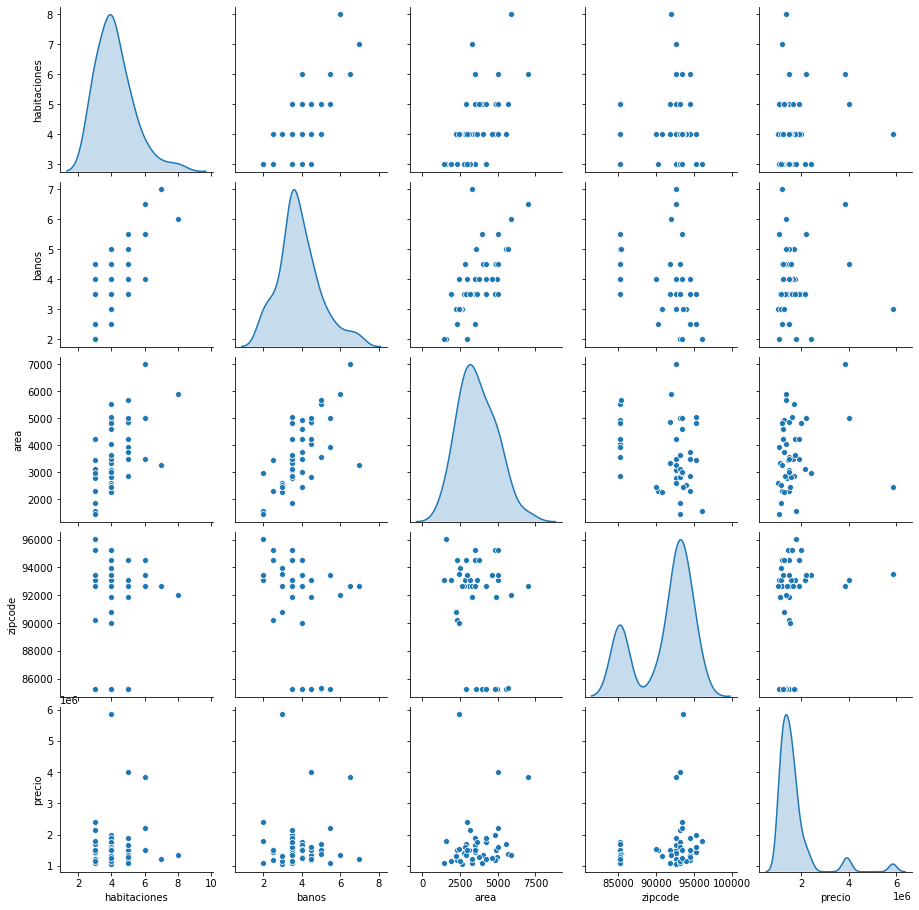

In [8]:
sns.pairplot(out_train[['habitaciones', 'banos', 'area', 'zipcode','precio']], diag_kind="kde")

In [15]:
train[train["area"]>= 5800]

,cod_casa,habitaciones,banos,area,zipcode,precio
34,PR4RVPF9D0VZKV9,4,1.0,9583,98021,395000
35,FZFBGHLP8HZGZIX,5,2.0,7627,98021,638940
68,OGEIWNUCLINIUIQ,4,2.0,7841,60016,299000
101,FN2KI2H293CITJU,6,6.5,7000,92677,3850000
210,SQRF6AJI6VX6GAB,8,6.0,5900,92040,1350000
441,4MYB1A4FTM1NB2C,4,3.5,9536,94531,460000


In [16]:
info_extra= pd.read_excel('info_zipcode.xlsx')

In [21]:
test

NameError: name 'test' is not defined

In [27]:
test[test.area>=4500]

,cod_casa,habitaciones,banos,area,zipcode
0,0R9Z8TJ4HVOWUAJ,4,5.0,4581,85266
2,92S3N8VWFYQRI0Q,6,6.5,5963,85262
11,77UD862RGS74V0H,5,4.5,4886,91901
24,M3ALUJ28M372IMT,4,2.5,6000,92677
45,3AHRQOTNDTEX1GK,5,5.0,4749,92880


In [32]:
train[train.zipcode== 85262]

,cod_casa,habitaciones,banos,area,zipcode,precio
3,VUCNPXL2QMIA22A,5,5.0,4022,85262,910000
5,W4MTH98D2INYX1L,3,4.0,2544,85262,799000
8,A6NMU8MK7WSHX5L,4,5.0,3550,85262,1500000
21,1UCKEG3053YCRN1,4,4.5,4031,85262,1345000
22,COZK137C0AMSOAA,4,4.0,4954,85262,1290000
23,55Y8BPUT85A3X1S,4,4.5,3550,85262,962500
29,JPK8W5Z8LFJEMGN,3,3.5,2873,85262,1695000
31,XEPQGNY2NUBJ9FO,5,5.5,3932,85262,1089000


In [36]:
entrega1.iloc[45]

'id'         '229'
'value'    1082254
Name: 45, dtype: object

In [28]:
info_extra[info_extra.zip_code== 85262]

,zip_code,population,population_density,housing_units,median_home_value,land_area,water_area,ocuppied_housing_units,median_household_income,travel_time_0_10,travel_time_10_20,travel_time_20_30,travel_time_30_40,travel_time_40_mas,porc_insc_public,porc_insc_priv,porc_insc_not
11,85262,11275.0,89.0,7273.0,619600.0,125.55,0.07,4892.0,125884.0,176.0,888.0,566.0,1184.0,325.0,77.9,16.2,6.0


In [29]:
info_extra[info_extra.zip_code== 92880]

,zip_code,population,population_density,housing_units,median_home_value,land_area,water_area,ocuppied_housing_units,median_household_income,travel_time_0_10,travel_time_10_20,travel_time_20_30,travel_time_30_40,travel_time_40_mas,porc_insc_public,porc_insc_priv,porc_insc_not
30,92880,58763.0,2380.0,16355.0,376500.0,24.69,0.67,15528.0,100452.0,975.0,4292.0,3733.0,4948.0,1796.0,80.2,10.9,9.0


In [35]:
train[train.zipcode== 92880]

,cod_casa,habitaciones,banos,area,zipcode,precio
182,H2UJGLXIE4UOKTE,5,3.00,3188,92880,567500
183,2VKA1ARQSMTHCEA,5,5.00,3701,92880,579000
184,G4SA11GKVQX1521,5,4.00,4014,92880,699000
185,8M1D5PCV76TNC8C,6,4.00,4311,92880,695000
186,LGML1WMV3M22MTP,5,4.00,2809,92880,635900
187,5BRA4BAG71GH9BD,6,4.00,3635,92880,585000
188,RTNR82ZWO4OOJ4P,8,6.00,3849,92880,580000
190,S4XRCRKMJHPL25G,4,3.00,3214,92880,547900
191,ACB0IPBCNXJHC8W,5,3.00,3677,92880,570000
192,NPB1WN11O0G2CAM,5,3.00,3200,92880,568000


La segunda vez sin regularizar "SampleSubmission_2" nuestro resultado fue de 75.982.672.892= 75.982 Millones

In [431]:
df.to_csv("sampleSubmission_2.csv")

In [ ]:
La segunda vez sin regularizar "SampleSubmission_2" nuestro resultado fue de 329.676.916.570= 75.982 Millones
